In [5]:
# set up headers / imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

In [6]:
draw_camera_calibration = 0

def Calibrate_Camera():
    """
    calibrates camera based on multiple images taken from that camera of chessboard pattern.
    used to undistort camera image and other camera based operations
    """
    
    images = glob.glob('./camera_cal/calibration*.jpg')

    # define grid shape (checker board pattern)
    grid_dims = (9,6)

    objp = np.zeros((grid_dims[0]*grid_dims[1],3), np.float32)
    objp[:,:2] = np.mgrid[0:grid_dims[0],0:grid_dims[1]].T.reshape(-1,2)

    objpoints = []
    imgpoints = []
    
    good_count = 0

    # loop through each image in cal folder
    for fname in images:    
        img = mpimg.imread(fname)

        #convert image to grayscale
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

        #detect chessboard corners in image
        ret, corners = cv2.findChessboardCorners(gray, grid_dims, None)

        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            
            good_count+=1
            
            # if debugging, draw out image with detected corners on top.
            if draw_camera_calibration > 0:
                img = cv2.drawChessboardCorners(img, grid_dims, corners, ret)
                plt.imshow(img)
                plt.show()
        else:
            print("could not detect corners: " + fname)

    # make sure we have at least 17 points (looks like at least three fail due to bad image capture)
    if(good_count >= 17):
        # calibrate the camera
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        if ret == False:
            print("calibrateCamera failed")
            return False, None, None, None, None

        return ret, mtx, dist, rvecs, tvecs
    else:
        # error - we cannot proceed unless this works
        return False, None, None, None, None

could not detect corners: ./camera_cal\calibration1.jpg
could not detect corners: ./camera_cal\calibration4.jpg
could not detect corners: ./camera_cal\calibration5.jpg
Distorted Image:


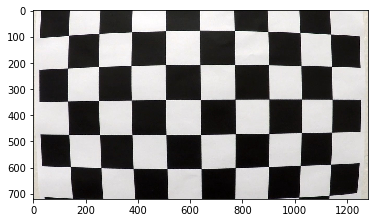

Undistorted Image:


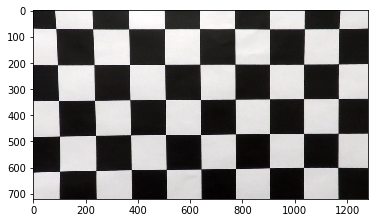

In [12]:
# generate camera calibration matrix / params
calCam_ret, calCam_mtx, calCam_dist, calCam_rvecs, calCam_tvecs = Calibrate_Camera()

if calCam_ret == False:
    print("calibrateCamera failed")

# test unproject of cal image 1 using our new camera calibration params
img = mpimg.imread("./camera_cal/calibration1.jpg")    

print("Distorted Image:")
plt.imshow(img)
plt.show()

print("Undistorted Image:")
dst = cv2.undistort(img, calCam_mtx, calCam_dist, None, calCam_mtx)

cv2.imwrite("output_images\calibration1_undistort.png", dst)

plt.imshow(dst)
plt.show()

In [13]:
def Run_Test_Images():
    """
    loops through each test image and unprojects it
    """
    images = glob.glob('./test_images/*.jpg')

    # loop through each image in cal folder
    for fname in images:    
        img = mpimg.imread(fname)
        
        dst = cv2.undistort(img, calCam_mtx, calCam_dist, None, calCam_mtx)
        plt.imshow(dst)
        plt.show()

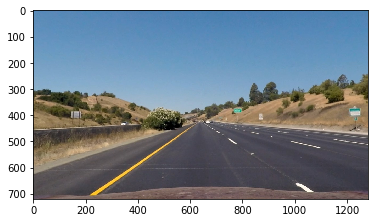

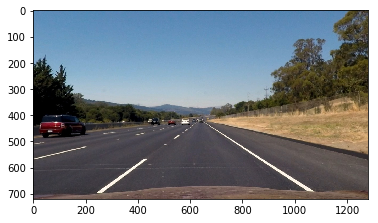

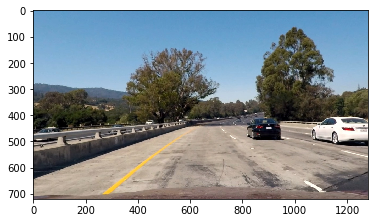

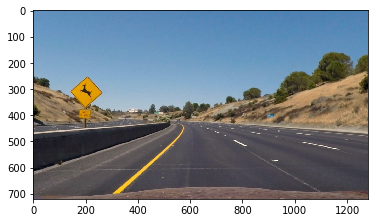

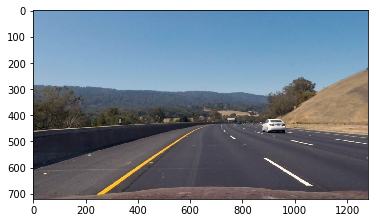

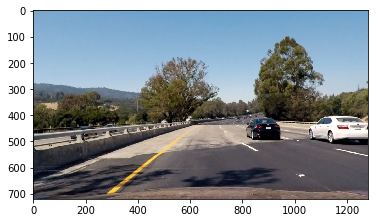

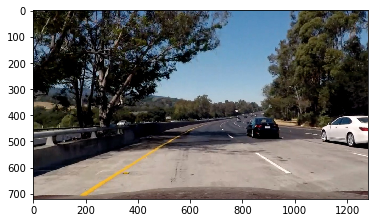

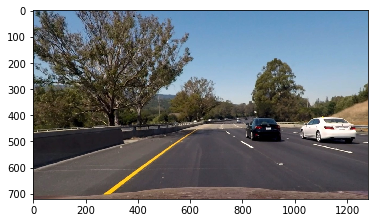

In [14]:
Run_Test_Images()

In [21]:
def GenerateCam2TopDownTransform(test_output=True):
    
    # load one of the road images with stated straight lines in:
    tImg = mpimg.imread('./test_images/straight_lines2.jpg')
    # undistort it using our camera cal info...
    dst = cv2.undistort(tImg, calCam_mtx, calCam_dist, None, calCam_mtx)
    # save the undistorted file to disk...
    cv2.imwrite("fixed_img.jpg", cv2.cvtColor(dst,cv2.COLOR_RGB2BGR))
    
    #... offline I loaded the image above into an image editng app and marked four points
    # that made a quad, the y values for the closest points were the same
    # and the y axis for the furthest points were the same
    # the points must fall on the left and right lane markings
    # I then made a set of output points, keeping the two closest points the same,
    # but making the y value for the furthest points to zero (the top of the image)
    # and x value to match the respective x value of the closest points...
    
    #inputPoints = np.array([[245, 692], [580,462], [703,462], [1059,692]],np.float32)
    #outputPoints = np.array([[245, 692], [245,0], [1059,0], [1059,692]],np.float32)
    
    inputPoints = np.array([[601, 446], [682, 446], [1014, 660], [302,660]],np.float32)
    outputPoints = np.array([[280, 0], [1000,0], [1000,720], [280,720]],np.float32)  
    
    # you can see the input points I selected on the marked image below
    if test_output == True:
        print("undistorted image with input points marked:")
        plt.imshow(dst)
        plt.plot(inputPoints[0][0], inputPoints[0][1], '.')
        plt.plot(inputPoints[1][0], inputPoints[1][1], '.')
        plt.plot(inputPoints[2][0], inputPoints[2][1], '.')
        plt.plot(inputPoints[3][0], inputPoints[3][1], '.')
        plt.show()

    # generate a matrix to transform input image to output image
    cam2TopDownTransform = cv2.getPerspectiveTransform(inputPoints, outputPoints)
    
    # while doing this, let's get the inverse too...
    cam2TopDownTransform_inverse = cv2.getPerspectiveTransform(outputPoints, inputPoints)
    
    # if debugging, apply the matrix to our test image, we should now see a top down view of our
    # picture with the lines parallel and straight (vertical)
    if test_output == True:
        # for visual confirmation, let's warp the image based off our new matrix and see what happens
        print("Warp to top down:")
        warp = cv2.warpPerspective(dst,cam2TopDownTransform,(tImg.shape[1],tImg.shape[0]))

        plt.imshow(warp)
        plt.show()
        
        # for fun let's warp it back with the inverse and see what that looks like...
        print("Unwarp back to camera viewpoint:")
        warpback = cv2.warpPerspective(warp,cam2TopDownTransform_inverse,(warp.shape[1],warp.shape[0]))

        plt.imshow(warpback)
        plt.show()
    
    return cam2TopDownTransform, cam2TopDownTransform_inverse

undistorted image with input points marked:


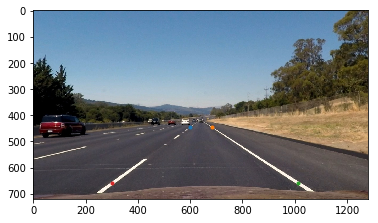

Warp to top down:


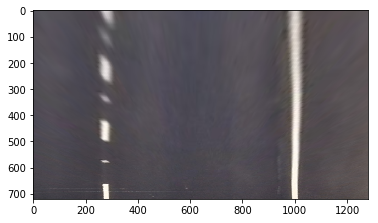

Unwarp back to camera viewpoint:


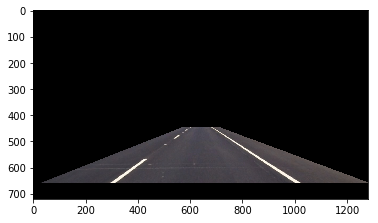

In [22]:
# we need to create a transformation matrix to turn our forward camera view to a top down camera view
# once generated this matrix can be reused.

cam2TopDownTransform, cam2TopDownTransform_inverse = GenerateCam2TopDownTransform(True)


In [ ]:
def TestWarpAllImages():
    
    images = glob.glob('./test_images/*.jpg')

    # loop through each image in cal folder
    for fname in images:    
        img = mpimg.imread(fname)
        
        dst = cv2.undistort(img, calCam_mtx, calCam_dist, None, calCam_mtx)
        
        warp = cv2.warpPerspective(dst, cam2TopDownTransform, (img.shape[1],img.shape[0]))

        plt.imshow(warp)
        plt.show()

In [ ]:
TestWarpAllImages()

In [ ]:
def Select_HLS_Channel(hls_image, channel_no=2, do_thresh=False, thresh=(0, 255)):

    channel = hls_image[:,:,channel_no]
    
    if do_thresh == True:
        # 2) Apply a threshold to the S channel
        binary_output = np.zeros_like(channel)

        binary_output[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    
        # 3) Return a binary image of threshold result
        return binary_output
    
    else:
        return channel
    

In [ ]:
def sobel_mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    return binary_output

In [ ]:
# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def sobel_dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the x and y gradients
    # Calculate the gradient magnitude
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)

    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dir = np.arctan2(abs_sobely, abs_sobelx)
    
    # 5) Create a binary mask where direction thresholds are met
    binary_output =  np.zeros_like(dir)
    binary_output[(dir >= thresh[0]) & (dir <= thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return binary_output

In [ ]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def sobel_abs_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        x = 1
        y = 0
    else:
        x = 0
        y = 1
    
    sobel = cv2.Sobel(gray, cv2.CV_64F, x, y, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    #plt.imshow(sbinary, cmap='gray')
    #plt.show()

    # 6) Return this mask as your binary_output image
    return sbinary

In [ ]:
def Example_Combining_Sobel_Techniques(image):
    
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = sobel_abs_thresh(image, orient='x', sobel_kernel=ksize, thresh=(0, 255))
    grady = sobel_abs_thresh(image, orient='y', sobel_kernel=ksize, thresh=(0, 255))
    mag_binary = sobel_mag_thresh(image, sobel_kernel=ksize, mag_thresh=(0, 255))
    dir_binary = sobel_dir_threshold(image, sobel_kernel=ksize, thresh=(0, np.pi/2))
    #Try different combinations and see what you get.

    #For example, here is a selection for pixels where both the x and y gradients meet the threshold criteria, or the gradient magnitude and direction are both within their threshold values.

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    #plt.imshow(image, cmap='gray')
    #plt.show()

In [ ]:
def filter_colors_hsv(img):
    """
    Convert image to HSV color space and suppress any colors
    outside of the defined color ranges
    """
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    #yellow_dark = np.array([15, 127, 127], dtype=np.uint8)
    #yellow_light = np.array([25, 255, 255], dtype=np.uint8)
    yellow_dark = np.array([15, 70, 150], dtype=np.uint8)
    yellow_light = np.array([40, 255, 255], dtype=np.uint8)
    yellow_range = cv2.inRange(hsv, yellow_dark, yellow_light)

    white_dark = np.array([0, 0, 200], dtype=np.uint8)
    white_light = np.array([255, 30, 255], dtype=np.uint8)
    white_range = cv2.inRange(hsv, white_dark, white_light)
    
    yellows_or_whites = yellow_range | white_range
    
    output = cv2.bitwise_and(img, img, mask=yellows_or_whites)
    
   
    return output

In [ ]:
def equalize_colors(image):
    
    #-----Converting image to LAB Color model----------------------------------- 
    lab= cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    cv2.imshow("original", cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

    #-----Splitting the LAB image to different channels-------------------------
    l, a, b = cv2.split(lab)
    #cv2.imshow('l_channel', l)
    #cv2.imshow('a_channel', a)
    #cv2.imshow('b_channel', b)

    #-----Applying CLAHE to L-channel-------------------------------------------
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    #cv2.imshow('CLAHE output', cl)

    #-----Merge the CLAHE enhanced L-channel with the a and b channel-----------
    limg = cv2.merge((cl,a,b))
    #cv2.imshow('limg', limg)

    #-----Converting image from LAB Color model to RGB model--------------------
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    cv2.imshow('equalized', cv2.cvtColor(final, cv2.COLOR_RGB2BGR))
    
    return final

In [ ]:
def compute_lane_lines(imgW, imgH, left_fit, right_fit):
    '''
    compute left and right lane line positions
    '''
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, imgH-1, imgH)
    
    left_fitx = None
    right_fitx = None
    
    if left_fit is not None:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    
    if right_fit is not None:
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

In [ ]:
def calculate_lane_radius(imgH, imgW, left_fit, right_fit):
    
    if (left_fit is None) or (right_fit is None):
        return None, None
    
    # first calculate the width of the road in pixels
    
    nearest_to_car_y = imgH-1 # calculate y point closest to car (by hood)
    
    left_fitx = left_fit[0]*nearest_to_car_y**2 + left_fit[1]*nearest_to_car_y + left_fit[2]
    right_fitx = right_fit[0]*nearest_to_car_y**2 + right_fit[1]*nearest_to_car_y + right_fit[2]
    
    lane_width_pixels = right_fitx - left_fitx
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/imgH # meters per pixel in y dimension
    xm_per_pix = 3.7/lane_width_pixels # meters per pixel in x dimension
    
    # calcualte where we are in realtion to center of the lane...
    
    lane_midpoint = lane_width_pixels / 2.0 + left_fitx
    offset_from_center_image = (imgW/2.0 - lane_midpoint) * -1
    
   
    offset_from_center_image *= xm_per_pix
    
    ## now calculate turn radius
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, imgH-1, imgH)
    
    leftx  = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    
    y_eval = np.max(ploty)
    left_curverad  = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters

    # take the average of the left and right lane to give a little smoothing
    average_curve_radius = (left_curverad + right_curverad) / 2.0
    
    return offset_from_center_image, average_curve_radius

In [ ]:
def visualize_lanes(binary_warped, left_fitx, right_fitx, ploty, left_lane_inds, right_lane_inds, nonzerox, nonzeroy, out_img):
        
    # Generate x and y values for plotting
    #ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    
    #left_fitx = None
    #right_fitx = None    
    
    #if left_fit is not None:
     #   left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    
    #if right_fit is not None:
    #    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    plt.imshow(out_img)
    
    left_pts = None
    right_pts = None
    
    if left_fitx is not None:
        plt.plot(left_fitx, ploty, color='red', linewidth=2)
        left_pts = np.column_stack((left_fitx, ploty)).astype(int)
        
    if right_fitx is not None:
        plt.plot(right_fitx, ploty, color='blue', linewidth=2)
        right_pts = np.column_stack((right_fitx, ploty)).astype(int)
        
    if (left_pts is not None) and (right_pts is not None): 
        color = [0,255,0]
        
        a3 = np.vstack((left_pts, np.flip(right_pts, 0)))

        cv2.fillPoly( out_img, a3.reshape(-1, a3.shape[0], a3.shape[1]), color )
        
        cv2.polylines(out_img,[right_pts],False,(255,0,0))
        cv2.polylines(out_img,[left_pts],False,(0,0,255))
        
        
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    return out_img

In [ ]:
def find_lane_lines(image_gray):

    if len(image_gray.shape) == 3:
        image_gray = cv2.cvtColor(image_gray, cv2.COLOR_RGB2GRAY)

    binary_warped = np.zeros_like(image_gray)
    binary_warped[image_gray > 0]=1
    
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = None
    right_fit = None
    
    if len(lefty) > 0 and len(leftx) > 0:
        left_fit = np.polyfit(lefty, leftx, 2)
        
    if len(righty) > 0 and len(rightx) > 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    #calculate_position_in_lane
    lane_position, turn_radius = calculate_lane_radius(binary_warped.shape[0], binary_warped.shape[1], left_fit, right_fit)
        
    left_fitx, right_fitx, ploty = compute_lane_lines(binary_warped.shape[0], binary_warped.shape[1], left_fit, right_fit)
    
    # plot the result so we can see how it did
    lane_line_mask = visualize_lanes(binary_warped, left_fitx, right_fitx, ploty, left_lane_inds, right_lane_inds, nonzerox, nonzeroy, out_img)
    
    return lane_line_mask, lane_position, turn_radius

In [ ]:
def Pipeline(image, undistort=True, warp=True, equalize=True):
    
    if undistort == True:
        dst = cv2.undistort(image, calCam_mtx, calCam_dist, None, calCam_mtx)
    else:
        dst = image
    
    if warp == True:
        warp = cv2.warpPerspective(dst, cam2TopDownTransform, (dst.shape[1],dst.shape[0]))
    else:
        warp = dst
    
    if equalize == True:
        eq = equalize_colors(warp)
    else:
        eq = warp

    color_filter = filter_colors_hsv(eq)
    
 
    #cv2.imshow('filtered', color_filter)
    #cv2.imshow('equalized', eq)
    #cv2.imshow('original', warp)
    
    ret = color_filter
    
    #ret = cv2.addWeighted(warp,0.5,ret,1.0,0)
    
    return ret
    
    cv2.imshow('filtered', cv2.cvtColor(color_filter, cv2.COLOR_RGB2BGR))

    # now try edge detection on s channel
   
    blur = cv2.GaussianBlur(eq,(15,15),0)
    
    hls = cv2.cvtColor(blur, cv2.COLOR_RGB2HLS)
    
    #h_channel = Select_HLS_Channel(hls, 0)
    #l_channel = Select_HLS_Channel(hls, 1)
    s_channel = Select_HLS_Channel(hls, 2)
    
 
    # Threshold color channel
    #s_thresh_min = 30
    #s_thresh_max = 255
    
    #s_thresh_min = 60
    #s_thresh_max = 255
    #s_binary = np.zeros_like(s_channel)
    #s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    #result = np.uint8(s_binary * 255)
    
    #return result
    
    #h_thresh_min = 30
    #h_thresh_max = 90
    #h_binary = np.zeros_like(h_channel)
    #h_binary[(h_channel >= h_thresh_min) & (h_channel <= h_thresh_max)] = 1
    
    #return np.uint8(s_binary * 255)
    
    
    ### test area ###
    ksize = 17
    #gradx_l = sobel_abs_thresh(l_channel, orient='x', sobel_kernel=ksize, thresh=(40, 60))
    gradx_s = sobel_abs_thresh(s_channel, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    
    #cv2.imshow('gradx_l', np.uint8(gradx_l * 255))
    cv2.imshow('gradx_s', np.uint8(gradx_s * 255))
    
    return np.uint8(gradx_s * 255)
    
    # merge results
    #combined = np.zeros_like(gradx_l)
    #combined[(gradx_l == 1) | (gradx_s == 1)] = 1
    
    ## TEST2 ##
    #gray = cv2.cvtColor(warp, cv2.COLOR_RGB2GRAY)
    #sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    #abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    #scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    #plt.imshow(sobelx, cmap='gray')
    #plt.show()
    #print(sobelx)
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    #color_binary = np.dstack(( np.zeros_like(gradx_l), gradx_l, gradx_s)) * 255
    
    result = gradx_s
    
    result = np.uint8(result * 255)
    
    lines = cv2.HoughLines(gradx_s,1,np.pi/180,200)
    for rho,theta in lines[0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(result,(x1,y1),(x2,y2),(0,0,255),2)
    
    result = result
    
    return result
    
    result = color_binary
    
    result = np.uint8(s_binary * 255)
    
    return result

In [ ]:
 # loop through each image in test_images folder
images = glob.glob('./test_images/*.jpg')
    
for fname in images:    
    img = mpimg.imread(fname)
        
    ret = Pipeline(img)
    
    find_lane_lines(ret)

    #plt.imshow(ret, cmap='gray')
    plt.imshow(ret)
    plt.show()
    

In [ ]:
import numpy as np

def plot_histo(img):
    
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    plt.plot(histogram)
    plt.show()

In [ ]:

proj = "project_video.mp4"
proj_hard = "challenge_video.mp4"
proj_hardest = "harder_challenge_video.mp4"

cap = cv2.VideoCapture(proj)

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('test_output.avi',fourcc, 25.0, (1280,720))

DRAW_OVERLAY_ON_VIDEO = True

while(cap.isOpened()):
    
    ret, frame = cap.read()
    
    if ret==False:
        break
        
    #frame = cv2.flip(frame,0)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    outFrame = Pipeline(frame) # image processing pipeline    
    
    outFrame, lane_position, turn_radius = find_lane_lines(outFrame) # lane detection / visualization code
    
    if DRAW_OVERLAY_ON_VIDEO:
        outFrame = cv2.warpPerspective(outFrame,cam2TopDownTransform_inverse,(outFrame.shape[1],outFrame.shape[0]))
        
        # blend road image with detected road
        outFrame = cv2.addWeighted(frame,0.7,outFrame,0.3,0)

        # write stats on image
        font                   = cv2.FONT_HERSHEY_SIMPLEX 
        topLeftCornerOfText    = (10,100)
        fontScale              = 0.8
        fontColor              = (255,255,255)
        lineType               = 2

        text = "Lane Offset: " + "{:.3f}".format(lane_position) + " meters"
        
        cv2.putText(outFrame,text, 
                    topLeftCornerOfText, 
                    font, 
                    fontScale,
                    fontColor,
                    lineType)
        
        text = "Curve Radius: " + "{:.3f}".format(turn_radius) + " meters"
        
        topLeftCornerOfText    = (10,200)
        
        cv2.putText(outFrame,text, 
                    topLeftCornerOfText, 
                    font, 
                    fontScale,
                    fontColor,
                    lineType)
    
    # write the processed frame
    #outFrame = cv2.cvtColor(outFrame, cv2.COLOR_GRAY2BGR)
    outFrame = cv2.cvtColor(outFrame, cv2.COLOR_RGB2BGR)
    
    #print(outFrame)
    #plot_histo(outFrame)

    out.write(outFrame)

    cv2.imshow('frame', outFrame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    

cap.release()
out.release()
cv2.destroyAllWindows()

In [ ]:
images = glob.glob('./test_images/*.jpg')
    
for fname in images:    
    img = mpimg.imread(fname)
    Example_Combining_Sobel_Techniques(img)